# Membership inference attack with images
## Target a CNN
Authors : Johan Jublanc

We use this article to simulate a membership inference attack : https://arxiv.org/pdf/1807.09173.pdf

Usefull reference : https://medium.com/disaitek/demystifying-the-membership-inference-attack-e33e510a0c39

### Imports

In [1]:
# !pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets

from os import listdir
from os.path import isfile, join

import urllib.request

import tarfile

from sklearn import metrics
import xgboost as xgb

from scipy.ndimage import rotate

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
tf.compat.v1.enable_eager_execution()

In [4]:
# tf.__version__ == 2.x
tf.__version__

'1.15.2'

## Get the data from cifar10

We use the CIFAR10 data which is a dataset of color images of size 32x32. For more information let's go here :
- https://www.cs.toronto.edu/~kriz/cifar.html

The process can take a while ;)

In [5]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
# urllib.request.urlretrieve(url, data_file_name)

In [6]:
import pathlib
data_dir = tf.keras.utils.get_file(origin=url, fname='cifar10', untar=True)

In [7]:
root_keras_data_path = "/".join(data_dir.split("/")[:5])
cifar_data_path = os.path.join(root_keras_data_path, "cifar-10-batches-py")
os.listdir(cifar_data_path)

['data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'batches.meta',
 'readme.html',
 'data_batch_1',
 'test_batch',
 'data_batch_5']

In [8]:
data_batches_names = []
for item in os.listdir(cifar_data_path):
    if item.startswith("data_batch"):
        data_batches_names.append(item)

CIFAR10 data are splited in batches. For this example the first batche is used to build up a classifier and the second one will be used to build up the attack.

In [9]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [10]:
data = []
for data_batches_name in data_batches_names:
    data.append(unpickle(os.path.join(cifar_data_path, data_batches_name)))
    print(data_batches_name)

data_batch_2
data_batch_3
data_batch_4
data_batch_1
data_batch_5


__Split data__

We firstly build a model that is trained on the dataset $data_b$, the dataset $data_a$ is used to evaluate the attack.

In [14]:
x_a = data[0][b"data"]
y_a = data[0][b"labels"]

x_b = data[1][b"data"]
y_b = data[1][b"labels"]

__Get a shadow dataset__

Here the attacker knows another dataset that is similar to D. Here we use batch 2.

In [15]:
x_prim_in = data[2][b"data"]
y_prim_in = data[2][b"labels"]
print(os.path.join(cifar_data_path, data_batches_names[0]))

/home/jupyter/.keras/datasets/cifar-10-batches-py/data_batch_2


__Batch 3 is used to get intput out of scope used to train the shadow model__

In [16]:
x_prim_out = data[3][b'data']
y_prim_out = data[3][b'labels']

__Define training parameters__

In [17]:
BATCH_SIZE = 32 # try 128 ?
IMG_HEIGHT = 224
IMG_WIDTH = 224
SHUFFLE_SIZE = 200 # buffer size ? try 1000 ? 
NUM_EPOCHS = 200

In [19]:
input_shape = (32, 32, 3)
num_classes = 10
len_train = 8000

In [20]:
train_target = True
train_shadow = True

## Function constituting the whole pipeline :
* reshape images
* create a MapDataset
* plt example images
* create a target
* load and save trained models

In [18]:
def reshape_images(flat_array):
    flat_array_normalized = tf.cast(flat_array, tf.float32) / 255.
    img_reshaped = tf.reshape(flat_array_normalized, (3, 32, 32))
    return tf.transpose(img_reshaped)

We define a function to create a dataset tensorflow

In [21]:
def input_fn(flat_arrays, labels, 
             BATCH_SIZE = BATCH_SIZE, 
             SHUFFLE_SIZE = SHUFFLE_SIZE, 
             NUM_EPOCHS = NUM_EPOCHS):
    ds_x = tf.data.Dataset.from_tensor_slices(flat_arrays)
    ds_x = ds_x.map(reshape_images)
    ds_y = tf.data.Dataset.from_tensor_slices(labels)
    ds_x_y = tf.data\
               .Dataset\
               .zip((ds_x, ds_y))\
               .shuffle(SHUFFLE_SIZE)\
               .repeat()\
               .batch(BATCH_SIZE)\
               .prefetch(1)
    return ds_x_y

In [22]:
# check dataset generation
dataset = input_fn(x_a, y_b)
print(dataset)

<DatasetV1Adapter shapes: ((?, 32, 32, 3), (?,)), types: (tf.float32, tf.int32)>


In [23]:
def plt_img_labels(img_batch, label_batch):
    plt.figure(figsize=(10,10))

    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        img = rotate(img_batch[n], -90)
        plt.imshow(img)
        plt.title(str(label_batch[n].numpy()))
        plt.axis('off')

A first model is trained on 80% of the $data_b$ and test on the 20% left
We use this article to build a quite good model : https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [24]:
def create_model(input_shape, opt):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), 
                     activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same', 
                     input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', 
                    kernel_initializer='he_uniform'))
    # model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=opt,
                  metrics=['sparse_categorical_accuracy'])
    return model

__Load/Save model__

In [25]:
if "models" not in os.listdir():
    os.mkdir("models")

In [26]:
import glob
def return_model_num(pattern):
    target_models_list = glob.glob(pattern)
    num_list = [x.split("/")[1].split(".")[0].split("_")[1] for x in target_models_list]
    num_list_int = [int(x) for x in num_list]
    return np.max(num_list_int)

In [27]:
def save_new_model(pattern, model):
    if len(glob.glob(pattern))==0:
        model.save(pattern.split("_")[0] + "_0.h5")
    else:
        num = return_model_num(pattern) + 1
        model.save(pattern.replace("*", str(num)))

In [28]:
def get_model(pattern, input_shape, opt):
    if len(glob.glob(pattern))==0:
        model = create_model(input_shape, opt)
    else:
        num = return_model_num(pattern)
        filepath = pattern.replace("*", str(num))
        model = tf.keras.models.load_model(filepath)
        print(filepath)
    return model

## Train target model

__Create dataset objects__

In [29]:
ds_xy_b = input_fn(x_b, y_b)
ds_xy_a = input_fn(x_a, y_a)

__Plot some example__

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


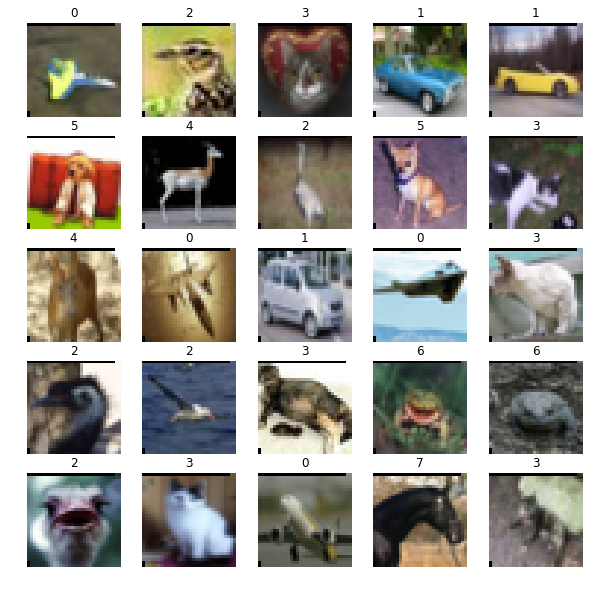

In [30]:
len_train = len(y_b)
img_batch, label_batch = next(iter(ds_xy_b))
plt_img_labels(img_batch, label_batch)

__Load pretrained or create a new model__

In [31]:
import tensorflow_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer

In [32]:
noise_multiplier = 1.1
l2_norm_clip = 1.5
num_microbatches = 1
learning_rate = 0.001

DP_opt = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

In [33]:
create_model(input_shape, DP_opt).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         7

In [34]:
pattern = 'models/targetDP1_*.h5'
target_model = get_model(pattern, input_shape, DP_opt)
score = target_model.evaluate(ds_xy_a, steps=200, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.304509941339493
Test accuracy: 0.10015625


In [ ]:
if train_target:
    history = target_model.fit(ds_xy_b,
                epochs=NUM_EPOCHS,
                steps_per_epoch=len_train//BATCH_SIZE,
                verbose=1,
                validation_data=(ds_xy_a),
                validation_steps=200)
    score = target_model.evaluate(ds_xy_a, steps=200, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

Epoch 1/200
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
312/312 [==============================] - 5s 15ms/step - loss: 2.3092 - sparse_categorical_accuracy: 0.0931 - val_loss: 2.3132 - val_sparse_categorical_accuracy: 0.0939
Epoch 2/200
312/312 [==============================] - 4s 13ms/step - loss: 2.3230 - sparse_categorical_accuracy: 0.0964 - val_loss: 2.3251 - val_sparse_categorical_accuracy: 0.1002
Epoch 3/200
312/312 [==============================] - 4s 14ms/step - loss: 2.3196 - sparse_categorical_accuracy: 0.1157 - val_loss: 2.3243 - val_sparse_categorical_accuracy: 0.1130
Epoch 4/200
312/312 [==============================] - 4s 14ms/step - loss: 2.3436 - sparse_categorical_accuracy: 0.1052 - val_loss: 2.3590 - val_sparse_categorical_accuracy: 0.0991
Epoch 5/200
312/312 [==============================] - 4s 14ms/step - loss: 2.3515 - sparse_categorical_accuracy: 0.0990 - val_loss: 2.3590 - val_sparse_categorical_accuracy: 0.0

__Save the model__

In [ ]:
save_new_model(pattern, target_model)

In [ ]:
target_model = get_model(pattern, input_shape, DP_opt)
target_model.summary()

## Train the shadow model

In [ ]:
ds_prim_in = input_fn(x_prim_in, y_prim_in)
ds_prim_out = input_fn(x_prim_out, y_prim_out)

img_batch, label_batch = next(iter(ds_prim_in))
plt_img_labels(img_batch, label_batch)

In [ ]:
pattern = 'models/primDP1_*.h5'
model_shadow = get_model(pattern,input_shape, DP_opt)
score = model_shadow.evaluate(ds_prim_out, steps=200, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
if train_shadow:
    history_shadow = model_shadow.fit(ds_prim_in,
                                  epochs=NUM_EPOCHS,
                                  steps_per_epoch=len_train//BATCH_SIZE,
                                  verbose=1,
                                  validation_data=(ds_prim_out),
                                  validation_steps=200)
    score = model_shadow.evaluate(ds_prim_out, steps=200, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [ ]:
save_new_model(pattern, model_shadow)

## Build up the attack

__Build a dataset $D^*$ to train the attack__

Now that we have trained our model on the "in" part of the data, we can make a prediction on both dataset's parts ("in" and "out") a labelise the results. The new dataset is named $D*$

In [ ]:
def input_fn_pred(x):
    ds_x = tf.data.Dataset.from_tensor_slices(x)\
                                  .map(reshape_images)\
                                  .batch(x.shape[0])
    return ds_x

In [ ]:
ds_x_prim_in = input_fn_pred(x_prim_in)
ds_x_prim_out = input_fn_pred(x_prim_out)

In [ ]:
x_star_in = model_shadow.predict(ds_x_prim_in)
y_star_in = [1 for i in range(len(x_star_in))]

x_star_out = model_shadow.predict(ds_x_prim_out)
y_star_out = [0 for i in range(len(x_star_out))]

In [ ]:
x_star = np.concatenate([x_star_in, x_star_out], axis=0)
y_star = np.concatenate([y_star_in, y_star_out], axis=0)

In [ ]:
len(x_star)

In [ ]:
from sklearn.model_selection import train_test_split
x_star_train, \
x_star_test, \
y_star_train, \
y_star_test = train_test_split(x_star, y_star, test_size =.2)

__Create XGBOOST attack model__

ref : https://www.datacamp.com/community/tutorials/xgboost-in-python#apply

In [ ]:
clf_attack  = xgb.XGBClassifier(objective ='reg:squarederror',
                                colsample_bytree = 0.8,
                                learning_rate = 0.01,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 20)

clf_attack.fit(x_star_train, y_star_train)
print("Accuracy:", metrics.accuracy_score(y_star_test, clf_attack.predict(x_star_test)))

In [ ]:
clf_attack  = xgb.XGBClassifier(objective ='reg:squarederror',
                                colsample_bytree = 0.3,
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 10)
clf_attack.fit(x_star,y_star)

# Test the attack against the true data set D

In [ ]:
def get_predictions_and_labels(target_model, attack_model, data, label):
    
    ds_data = input_fn_pred(data)
    
    # Information we have thanks to the API (original model)
    probas   = target_model.predict(ds_data)

    # Model we have trained to make the attack
    prediction = clf_attack.predict(probas)

    # Results zipping prediction an true labels
    result  = pd.DataFrame(zip(prediction, [label for i in range(len(probas))]), 
                           columns = ("y_pred", "y"))
    
    return result

Results for images out of the training dataset

In [ ]:
results_a = get_predictions_and_labels(target_model = target_model, 
                                       attack_model=clf_attack, 
                                       data=x_a, label=0)

Results for images in the training dataset

In [ ]:
results_b = get_predictions_and_labels(target_model = target_model, 
                                       attack_model=clf_attack,
                                       data=x_b, label=1)

Measure the accuracy of the attack

In [ ]:
attack_results = pd.concat([results_a, results_b]).reset_index().drop("index", axis=1)

In [ ]:
print("Accuracy:", metrics.accuracy_score(attack_results["y"], attack_results["y_pred"]))

## save results

In [ ]:
target_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=DP_opt,
                  metrics=['sparse_categorical_accuracy'])

In [ ]:
model_shadow.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     optimizer=DP_opt,
                     metrics=['sparse_categorical_accuracy'])

In [ ]:
result_dict = {
    "dataset" : ["cifar10"],
    "attack_model" : ["XGBoost"],
    "accuracy_target" : [target_model.evaluate(ds_xy_a, steps=200, verbose=0)[1]],
    "accuracy_shadow" : [model_shadow.evaluate(ds_prim_out, steps=200, verbose=0)[1]],
    "accurracy_attack" : [metrics.accuracy_score(attack_results["y"], attack_results["y_pred"])],
    "DP_multiplicator" : [noise_multiplier]
}

result_pd = pd.DataFrame(result_dict)

In [ ]:
if "results.csv" in os.listdir("models"):
    main_pd = pd.read_csv("models/results.csv", index_col=0)
    result_pd = pd.concat([main_pd, result_pd], ignore_index=True)

In [ ]:
result_pd.to_csv("models/results.csv")